<a href="https://colab.research.google.com/github/dolmani38/drift/blob/main/real_data_drift_test_0919.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Default Prediction - Neural Network

https://www.kaggle.com/errearanhas/default-prediction-neural-network-99-acc

##Introduction

Using historical data on loans from Lendig Club - including information on whether or not the borrower defaulted (charge-off) - the main objective of this notebook will be to predict if a potential borrower is likely to pay back the loan.

After explore and pre-process data, we are going to train a Neural Network binary classification model in order to achive this objective. Finally, we evaluate model performance and simulate its operation with a new customer prediction.

Notebook sections:

1. Import data
2. Exploratory Data Analysis
3. Pre-processing
4. Define and train Model
5. Evaluate Model

p.s. work inspired by the excellent Tf2 and Keras DL Bootcamp

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

!pip3 install shap
!pip3 install alibi-detect
!pip3 install lime

     |████████████████████████████████| 356 kB 6.9 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491652 sha256=e24807937fb3ef2437c9a1f8f11e8be17bc026378b2370387d7e555ab1281028
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
     |████████████████████████████████| 207 kB 7.8 MB/s 
     |████████████████████████████████| 454.4 MB 9.2 kB/s 
     |████████████████████████████████| 4.8 MB 60.4 MB/s 
     |████████████████████████████████| 2.8 MB 33.4 MB/s 
     |████████████████████████████████| 4.0 MB 49.4 MB/s 
     |████████████████████████████████| 1.2 MB 36.2 MB/s 
     |████████████████████████████████| 462 kB 50.8 MB/s 
     |████████████████████████████████| 895 kB 44.4 MB/s 
     |████████████████████████████████| 636 kB 49.7 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 3.3 MB 36.6 MB/s 
  Attempting unin

     |████████████████████████████████| 275 kB 8.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=661c376068a517179aadfc9bb1c34ec28d6b70608dd2fb9f3bc91c6136acd4f4
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [4]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2260701, 151)


##Exploratory Data Analysis (and some initial pre-processing)

Since we are going to predict loan_status, let's take a brief closer look on it:

In [5]:
df_accepted.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

for the sake of simplicity, let's consider only Fully Paid and Charged Off values:

In [6]:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]

print(df_accepted.shape)

(1345310, 151)


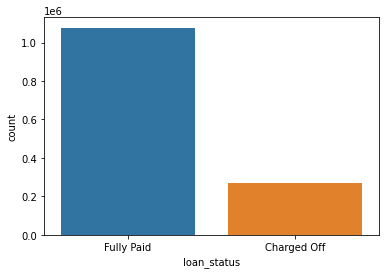

In [7]:
sns.countplot(x="loan_status", data=df_accepted)

checking now null values per columns:

In [8]:
df_accepted.isnull().sum().sort_values(ascending=False)

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_end_date                             1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
hardship_flag                                       0
fico_range_high                                     0
id                                                  0
Length: 151, dtype: int64

wow, there is a bunch of columns almost full of missing values. Let's check the first 50 columns sorted by missing values:

In [9]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_end_date                             1339556
payment_plan_start_date                       1339556
hardship_length                               1339556
hardship_dpd                                  1339556
hardship_loan_status                          1339556
hardship_last_payment_amount                  1339556
hardship_payoff_balance_amount                1339556
hardship_amount                               1339556
hardship_status                               1339556
hardship_reason                               1339556
hardship_type                                 1339556
deferral_term                                 1339556
sec_app_mths_since_last_major_derog           1338665
sec_app_revol_util                            1327008
revol_bal_joint             

let's drop these columns, as it will not contribute to our goal.

In [10]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 101)

let's check again:

In [11]:
df_accepted.isnull().sum().sort_values(ascending=False).head(50)

open_il_24m                   807712
inq_fi                        807712
open_rv_24m                   807712
open_rv_12m                   807712
open_act_il                   807712
max_bal_bc                    807712
total_bal_il                  807712
mths_since_last_delinq        678743
mths_since_recent_inq         174071
num_tl_120dpd_2m              117401
mo_sin_old_il_acct            105575
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67549
num_rev_accts                  67528
mo_sin_old_rev_tl_op           67528
mo_sin_rcnt_rev_tl_op          67528
mo_sin_rcnt_tl                 67527
num_accts_ever_120_pd          67527
num_actv_rev_tl                67527
num_actv_bc_tl                 67527
num_bc_tl                      67527
num_tl_op_past_12m             67527
num_tl_90g_dpd_24m             67527
total_il_high_credit_limit     67527
tot_coll_amt                   67527
t

maybe we can go further, and eliminate columns up to title:

In [12]:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1345310, 56)

In [13]:
print(df_accepted['issue_d'])

0          Dec-2015
1          Dec-2015
2          Dec-2015
4          Dec-2015
5          Dec-2015
             ...   
2260688    Oct-2016
2260690    Oct-2016
2260691    Oct-2016
2260692    Oct-2016
2260697    Oct-2016
Name: issue_d, Length: 1345310, dtype: object


for the remaining columns with missing values, let's see the missing percentage:

In [14]:
nulls = df_accepted.isnull().sum().sort_values(ascending=False)
nulls_percentage = (nulls/df_accepted.shape[0]*100)
nulls_percentage.head(15)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
collections_12_mths_ex_med    0.004163
chargeoff_within_12_mths      0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
zip_code                      0.000074
inq_last_6mths                0.000074
issue_d                       0.000000
addr_state                    0.000000
delinq_2yrs                   0.000000
earliest_cr_line              0.000000
purpose                       0.000000
dtype: float64

Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():

In [15]:
df_accepted = df_accepted.dropna()
df_accepted.shape

(1341026, 56)

In [16]:
df_accepted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   funded_amnt                 1341026 non-null  float64
 3   funded_amnt_inv             1341026 non-null  float64
 4   term                        1341026 non-null  object 
 5   int_rate                    1341026 non-null  float64
 6   installment                 1341026 non-null  float64
 7   grade                       1341026 non-null  object 
 8   sub_grade                   1341026 non-null  object 
 9   home_ownership              1341026 non-null  object 
 10  annual_inc                  1341026 non-null  float64
 11  verification_status         1341026 non-null  object 
 12  issue_d                     1341026 non-null  object 
 1

let's now take a look at loan_amnt histogram, to have an idea of the amount distribution:

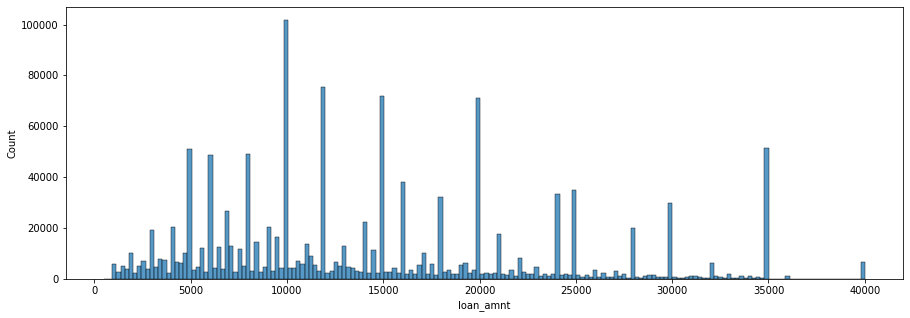

In [17]:
plt.figure(figsize=(15,5))
sns.histplot(df_accepted.loan_amnt, kde=False)

let's now see the correlation between continuous variables:

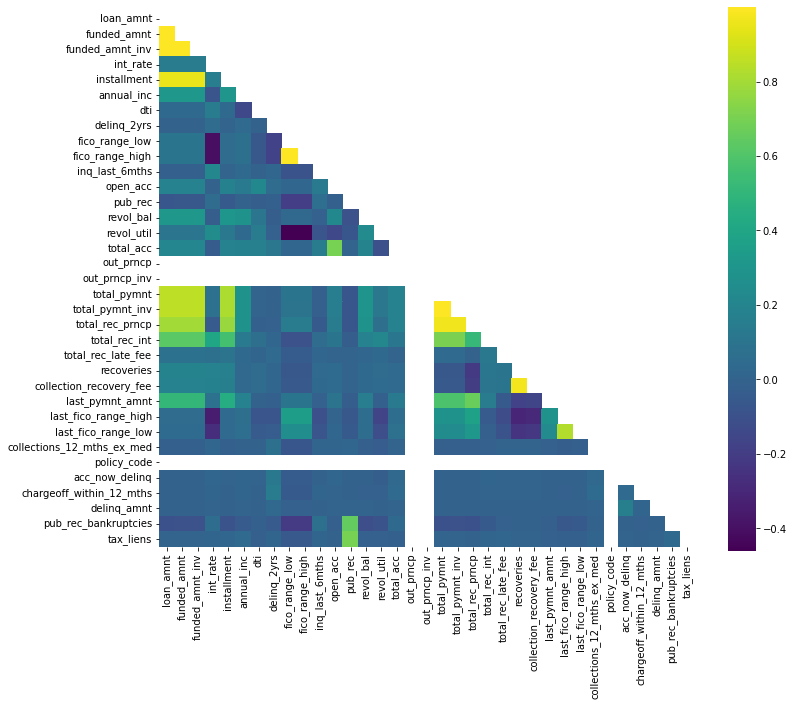

In [18]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

there are 3 columns with a visible different behaviour: out_prncp, out_prncp_inv and policy_code.

In [19]:
print(df_accepted.out_prncp.value_counts())
print(df_accepted.out_prncp_inv.value_counts())
print(df_accepted.policy_code.value_counts())

0.0    1341026
Name: out_prncp, dtype: int64
0.0    1341026
Name: out_prncp_inv, dtype: int64
1.0    1341026
Name: policy_code, dtype: int64


These are constant columns. We can drop it either.

In [20]:
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 53)

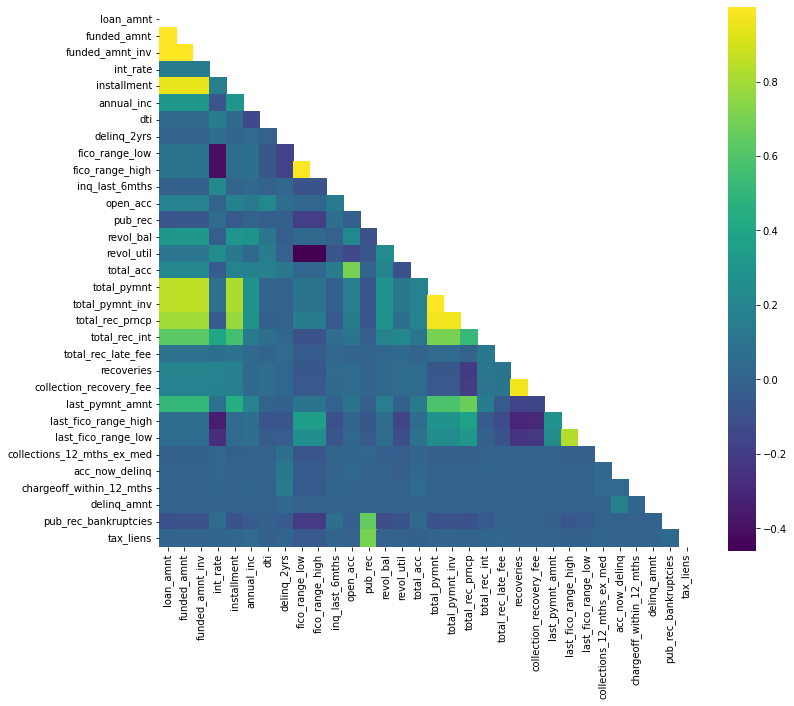

In [21]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(df_accepted.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_accepted.corr(), cmap='viridis', mask=mask, annot=False, square=True)

There are many yellowish squares. This indicates almost perfect correlation between many variables. Let's dig deeper:

In [22]:
# unstacking correlation to check highest correlation pairs

c = df_accepted.corr().abs()
unstack_corr = c.unstack()
pairs = unstack_corr.sort_values(ascending=False)

corr_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_pairs.columns = ['feature1', 'feature2', 'corr']


# check feature pairs above 0.8 in correlation

cond1 = (corr_pairs.feature1 != corr_pairs.feature2)
cond2 = (corr_pairs['corr']>0.80)

corr_pairs[cond1 & cond2]

,feature1,feature2,corr
1,fico_range_high,fico_range_low,1.000000
2,loan_amnt,funded_amnt,0.999565
3,total_pymnt,total_pymnt_inv,0.999541
4,funded_amnt_inv,funded_amnt,0.999439
5,loan_amnt,funded_amnt_inv,0.998918
6,collection_recovery_fee,recoveries,0.972674
7,total_rec_prncp,total_pymnt,0.967104
8,total_rec_prncp,total_pymnt_inv,0.966725
9,funded_amnt,installment,0.954037
10,funded_amnt_inv,installment,0.953445


Let's perform scatterplot and visually check some relationships among these features:

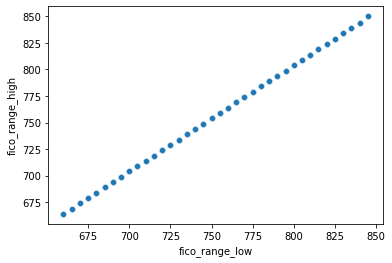

In [23]:
sns.scatterplot(x=df_accepted.fico_range_low, y=df_accepted.fico_range_high)

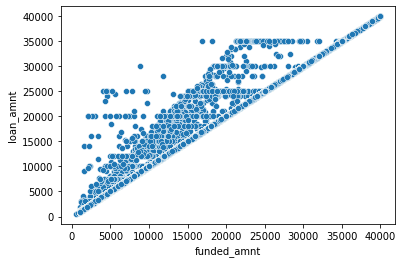

In [24]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.loan_amnt)

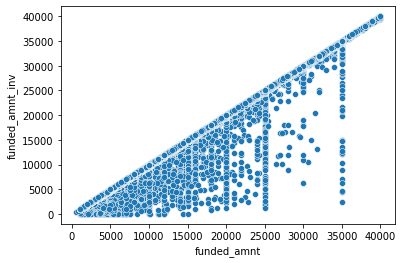

In [25]:
sns.scatterplot(x=df_accepted.funded_amnt, y=df_accepted.funded_amnt_inv)

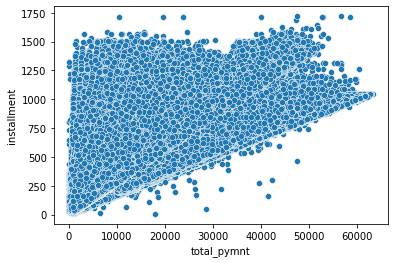

In [26]:
sns.scatterplot(x=df_accepted.total_pymnt, y=df_accepted.installment)

It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:

In [27]:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

(1341026, 44)

as our target column is categorical (loan_status), let's create a new feature - loan_paid - that is 1 for 'Fully Paid' and 0 for 'Charged Off'

In [28]:
values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

In [29]:
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)

df_accepted = df_accepted.drop(columns=['loan_status'])

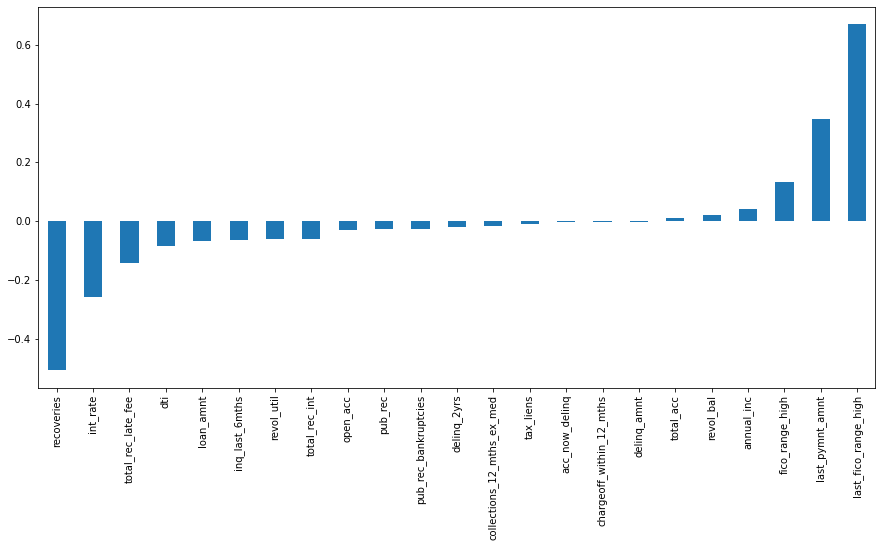

In [30]:
# checking correlation of features to the new loan_paid column


plt.figure(figsize=(15,7))
new_corr = df_accepted.corr().iloc[:-1,-1].sort_values()
new_corr.plot.bar(rot=90)

##Pre-processing

we still have many string categorical columns. Let's work on it:

In [31]:
df_accepted.head()

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,collections_12_mths_ex_med,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,5.91,0.0,Aug-2003,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,821.72,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,16.06,1.0,Dec-1999,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,979.66,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,10.78,0.0,Aug-2000,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,2705.92,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,0.0,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,25.37,1.0,Jun-1998,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,1340.50,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,10.20,0.0,Oct-1987,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,w,1758.95,0.0,0.0,May-2017,7653.56,May-2017,759.0,0.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1


In [32]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)
df_accepted[cat_cols]

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


,id,term,grade,sub_grade,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
4,68476807,60 months,F,F1,MORTGAGE,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N
5,68426831,36 months,C,C3,RENT,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,Oct-1987,w,May-2017,May-2017,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,60 months,B,B2,OWN,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,775xx,TX,Jul-2004,f,Aug-2018,Mar-2019,Individual,N,Cash,N
2260690,88948836,60 months,C,C3,MORTGAGE,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,900xx,CA,Mar-2002,f,Jul-2018,Jul-2018,Individual,N,Cash,N
2260691,89996426,60 months,C,C4,MORTGAGE,Source Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,863xx,AZ,Jun-2011,f,Mar-2017,Dec-2018,Individual,N,Cash,N
2260692,90006534,60 months,C,C1,RENT,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,medical,284xx,NC,Aug-1997,f,Mar-2018,Mar-2019,Individual,N,Cash,N


In [33]:
# droping constant columns

print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())

cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
df_accepted.shape

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


(1341026, 41)

In [34]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


In [35]:
print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

 36 months    1017398
 60 months     323628
Name: term, dtype: int64


In [36]:
print(df_accepted.grade.value_counts())
print(df_accepted.sub_grade.value_counts())

B    391850
C    380490
A    234657
D    200019
E     93126
F     31854
G      9030
Name: grade, dtype: int64
C1    85247
B4    83003
B5    82327
B3    81658
C2    78960
C3    74781
C4    74173
B2    73870
B1    70992
C5    67329
A5    63892
A4    52135
D1    51092
D2    44637
A1    43634
D3    39134
A3    37900
A2    37096
D4    35412
D5    29744
E1    23657
E2    21244
E3    18279
E4    15621
E5    14325
F1     9914
F2     7149
F3     6055
F4     4826
F5     3910
G1     2967
G2     2109
G3     1600
G4     1259
G5     1095
Name: sub_grade, dtype: int64


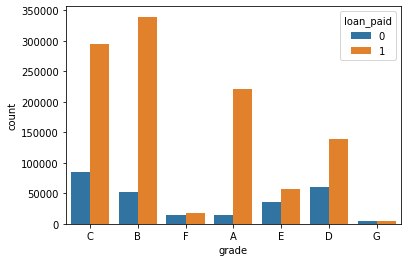

In [37]:
# checking count per grade and loan_paid

sns.countplot(x=df_accepted.grade, hue=df_accepted.loan_paid)

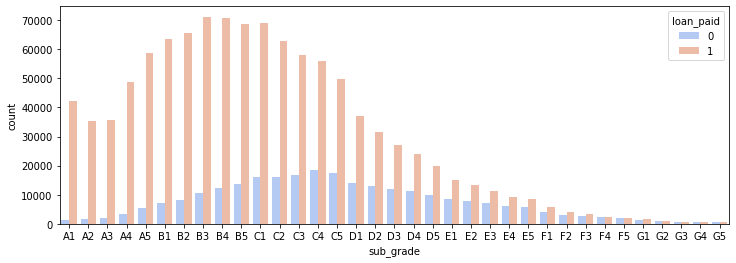

In [38]:
# checking count per subgrade and loan_paid

l = list(df_accepted.sub_grade.unique())
l.sort()

plt.figure(figsize=(12,4))
sns.countplot(x=df_accepted.sub_grade, order=l, hue=df_accepted.loan_paid, palette='coolwarm')

In [39]:
# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

In [40]:
df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

In [41]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


features verification_status, application_type, initial_list_status, purpose

In [42]:
print(df_accepted.verification_status.unique())
print(df_accepted.application_type.unique())
print(df_accepted.initial_list_status.unique())
print(df_accepted.purpose.unique())

['Not Verified' 'Source Verified' 'Verified']
['Individual' 'Joint App']
['w' 'f']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']


In [43]:
# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

In [44]:
df_accepted

,loan_amnt,term,int_rate,home_ownership,annual_inc,issue_d,url,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,disbursement_method,debt_settlement_flag,loan_paid,A2,A3,A4,A5,B1,...,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Source Verified,Verified,Joint App,w,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
0,3600.0,36,13.99,MORTGAGE,55000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,190xx,PA,5.91,0.0,Aug-2003,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,821.72,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,24700.0,36,11.99,MORTGAGE,65000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,577xx,SD,16.06,1.0,Dec-1999,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,979.66,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,20000.0,60,10.78,MORTGAGE,63000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,605xx,IL,10.78,0.0,Aug-2000,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,2705.92,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,10400.0,60,22.45,MORTGAGE,104433.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,174xx,PA,25.37,1.0,Jun-1998,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1340.50,0.0,0.0,Jul-2016,10128.96,Mar-2018,704.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5,11950.0,36,13.44,RENT,34000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,300xx,GA,10.20,0.0,Oct-1987,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,1758.95,0.0,0.0,May-2017,7653.56,May-2017,759.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,60,9.49,OWN,130000.0,Oct-2016,https://lendingclub.com/browse/loanDetail.acti...,775xx,TX,20.59,0.0,Jul-2004,739.0,1.0,17.0,0.0,23833.0,34.0,39.0,2756.23,0.0,0.0,Aug-2018,12828.77,Mar-2019,709.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2260690,29400.0,60,13.99,MORTGAGE,180792.0,Oct-2016,https://lendingclub.com/browse/loanDetail.acti...,900xx,CA,22.03,0.0,Mar-2002,709.0,1.0,16.0,0.0,77480.0,85.2,32.0,6448.76,0.0,0.0,Jul-2018,22192.81,Jul-2018,719.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2260691,32000.0,60,14.49,MORTGAGE,157000.0,Oct-2016,https://lendingclub.com/browse/loanDetail.acti...,863xx,AZ,10.34,0.0,Jun-2011,739.0,0.0,14.0,0.0,111598.0,27.4,18.0,1861.47,0.0,0.0,Mar-2017,752.74,Dec-2018,499.0,0.0,0.0,0.0,0.0,0.0,0.0,Cash,N,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2260692,16000.0,60,12.79,RENT,150000.0,Oct-2016,https://lendingclub.com/browse/loanDetail.acti...,284xx,NC,12.25,0.0,Aug-1997,669.0,0.0,12.0,4.0,7700.0,55.0,28.0,2660.61,0.0,0.0,Mar-2018,12874.54,Mar-2019,684.0,0.0,0.0,0.0,0.0,3.0,0.0,Cash,N,1,

In [45]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['home_ownership', 'issue_d', 'url', 'zip_code', 'addr_state',
       'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


feature home_ownership

In [46]:
df_accepted.home_ownership.value_counts()

MORTGAGE    663868
RENT        532493
OWN         144195
ANY            283
OTHER          142
NONE            45
Name: home_ownership, dtype: int64

In [47]:
df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)

features issue_d, url, last_pymnt_d and last_credit_pull_d

--> 여기서는 issue_d column을 drop 했지만... 우리는 이걸 살린다!!!

In [48]:
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])

In [49]:
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])

In [50]:
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['issue_d', 'earliest_cr_line', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


features disbursement_method and debt_settlement_flag

In [51]:
print(df_accepted.disbursement_method.value_counts())
print(df_accepted.debt_settlement_flag.value_counts())

Cash         1334162
DirectPay       6864
Name: disbursement_method, dtype: int64
N    1307844
Y      33182
Name: debt_settlement_flag, dtype: int64


In [52]:
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)

feature earliest_cr_line

In [53]:
print(df_accepted.earliest_cr_line.value_counts())

Aug-2001    9365
Aug-2002    9066
Sep-2003    9000
Oct-2001    8838
Aug-2000    8822
            ... 
Sep-1953       1
May-1950       1
Nov-1955       1
Nov-1953       1
Jul-1952       1
Name: earliest_cr_line, Length: 739, dtype: int64


In [54]:
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])

In [55]:
df_accepted.shape

(1341026, 83)

In [56]:
df_accepted

,loan_amnt,term,int_rate,annual_inc,issue_d,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,loan_paid,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,...,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,Source Verified,Verified,Joint App,w,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,MORTGAGE,OTHER,OWN,RENT,DirectPay,Y
0,3600.0,36,13.99,55000.0,Dec-2015,5.91,0.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,821.72,0.0,0.0,122.67,564.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,24700.0,36,11.99,65000.0,Dec-2015,16.06,1.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,979.66,0.0,0.0,926.35,699.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,20000.0,60,10.78,63000.0,Dec-2015,10.78,0.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,2705.92,0.0,0.0,15813.30,704.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,10400.0,60,22.45,104433.0,Dec-2015,25.37,1.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1340.50,0.0,0.0,10128.96,704.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
5,11950.0,36,13.44,34000.0,Dec-2015,10.20,0.0,694.0,0.0,5.0,0.0,8822.0,68.4,6.0,1758.95,0.0,0.0,7653.56,759.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,60,9.49,130000.0,Oct-2016,20.59,0.0,739.0,1.0,17.0,0.0,23833.0,34.0,39.0,2756.23,0.0,0.0,12828.77,709.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2260690,29400.0,60,13.99,180792.0,Oct-2016,22.03,0.0,709.0,1.0,16.0,0.0,77480.0,85.2,32.0,6448.76,0.0,0.0,22192.81,719.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2260691,32000.0,60,14.49,157000.0,Oct-2016,10.34,0.0,739.0,0.0,14.0,0.0,111598.0,27.4,18.0,1861.47,0.0,0.0,752.74,499.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2260692,16000.0,60,12.79,150000.0,Oct-2016,12.25,0.0,669.0,0.0,12.0,4.0,7700.0,55.0,28.0,2660.61,0.0,0.0,12874.54,684.0,0.0,0.0,0.0,0.0,3.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


날짜 (issue_d) 정리 및 sort

In [57]:
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

In [58]:
def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

'200901'

In [59]:
 df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
 df_accepted = df_accepted.sort_values(by='issue_d')
 df_accepted.reset_index(drop=True, inplace=True)

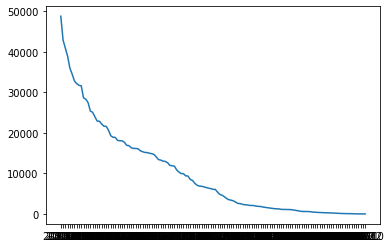

In [60]:
plt.plot(df_accepted['issue_d'].value_counts())

In [61]:
df_accepted[df_accepted['issue_d'].str.startswith('2009')]['issue_d'].value_counts()

200912    597
200911    595
200910    543
200909    445
200908    407
200907    372
200906    353
200905    319
200904    287
200903    275
200902    259
200901    236
Name: issue_d, dtype: int64

##Creating a Neural Network Model

now we are ready to start our modelling phase. First, let's apply a train-test-split and scale data before training.

2007,2008,2009 년도 데이터로 학습하고, 이후 각 년도별 Acc를 측정한다.

In [62]:
X = {}
Y = {}

In [63]:
# sampling data

# df = df_accepted.sample(frac=0.8,random_state=42)
# print(len(df))

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df.drop(columns=['issue_d'])


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [64]:
X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values

In [65]:
for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


각 년도별 학습

In [66]:
ML = {}
scaler = MinMaxScaler()

In [67]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [81]:
MODEL_TYPE = 'RF'  ## RF / DL

## Deep Learning 모델

In [78]:
import os.path 

def build_model_dl(year,x,y,epochs=5):
    #X_train, X_test, y_train, y_test = train_test_split(X[year], Y[year], test_size=0.2, random_state=42)
    X_train= scaler.fit_transform(x)
    #X_test = scaler.transform(X_test)
    y_train = get_one_hot(y,2)

    # building the model
    model = Sequential()
    model.add(Dense(units=78,activation='relu'))
    model.add(Dense(units=39,activation='relu'))
    model.add(Dense(units=19,activation='relu'))
    model.add(Dense(units=8,activation='relu'))
    model.add(Dense(units=4,activation='relu'))
    model.add(Dense(units=2,activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    weight_path = '/content/drive/MyDrive/Drift/model/ml_'+str(year)
    if os.path.exists(weight_path+'.index'):
        model.load_weights(weight_path)
        print('load weights from ',weight_path)
    else:
        model.fit(x=X_train, 
                y=y_train, 
                epochs=epochs,
                batch_size=512,
                verbose=1)
            #validation_data=(X_test, y_test), verbose=1)
        if year > 2000:
            model.save_weights(weight_path) 
            print('save weights to ',weight_path)
    return model

## Rabdom forest model build

In [83]:
from sklearn.ensemble import RandomForestClassifier

def build_model_rf(year,x,y,epochs=5):
    X_train= scaler.fit_transform(x)
    y_train = y #get_one_hot(y,2)
    model = RandomForestClassifier(n_estimators=80,max_depth=5)
    model.fit(x,y)
    return model

In [84]:
%rm -f /content/drive/MyDrive/Drift/model/checkpoint

for year in range(2009,2019):
    # building the model
    print(str(year) + '년도 학습 ======================================')
    epochs = 100 #(100 if year==2009 else 5)
    if MODEL_TYPE =='DL':
        ML[year] = build_model_dl(year,X[year],Y[year],epochs=epochs)
    else:
        ML[year] = build_model_rf(year,X[year],Y[year],epochs=epochs)
            

2009년도 학습 ======================================
2010년도 학습 ======================================
2011년도 학습 ======================================
2012년도 학습 ======================================
2013년도 학습 ======================================
2014년도 학습 ======================================
2015년도 학습 ======================================
2016년도 학습 ======================================
2017년도 학습 ======================================
2018년도 학습 ======================================


Evaluate model

In [75]:
metric = np.zeros((10,10))
mdf = pd.DataFrame(metric,columns=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'],index=['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'])


In [85]:
# 2009년 학습으로 2010~2018년까지의 acc 비교
for model_year in range(2009,2019):
    print('model:',model_year)
    for year in range(2009,2019):
        print('\ttest:',year)
        X_test = scaler.fit_transform(X[year])
        if MODEL_TYPE =='DL':
            predictions = (ML[model_year].predict(X_test)[:,1] > 0.5).astype("int32")
        else:
            predictions = (ML[model_year].predict(X_test) > 0.5).astype("int32")
        acc = accuracy_score(Y[year], predictions)
        print('\tacc:',acc)
        mdf.iloc[year-2009,model_year-2009] = acc

mdf

model: 2009
	test: 2009
	acc: 0.9168535449370364
	test: 2010
	acc: 0.9243280855875445
	test: 2011
	acc: 0.9155709342560554
	test: 2012
	acc: 0.9313931656027037
	test: 2013
	acc: 0.9397070402448264
	test: 2014
	acc: 0.9315103535557531
	test: 2015
	acc: 0.9216130614682421
	test: 2016
	acc: 0.8996733311669431
	test: 2017
	acc: 0.8800418134194943
	test: 2018
	acc: 0.8825181371401826
model: 2010
	test: 2009
	acc: 0.8921856132482319
	test: 2010
	acc: 0.8965817169696443
	test: 2011
	acc: 0.8838292964244522
	test: 2012
	acc: 0.8898422831393166
	test: 2013
	acc: 0.9045949519409326
	test: 2014
	acc: 0.9001669494035598
	test: 2015
	acc: 0.8814518193064028
	test: 2016
	acc: 0.860839077117789
	test: 2017
	acc: 0.8512356934553683
	test: 2018
	acc: 0.8772255126104881
model: 2011
	test: 2009
	acc: 0.9073658789028808
	test: 2010
	acc: 0.9154562059667739
	test: 2011
	acc: 0.9068512110726643
	test: 2012
	acc: 0.9210289147577919
	test: 2013
	acc: 0.9323384784514136
	test: 2014
	acc: 0.9260844979400598
	te

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
2009,0.916854,0.892186,0.907366,0.907193,0.918234,0.931171,0.872520,0.931171,0.861653,0.872003
2010,0.924328,0.896582,0.915456,0.915630,0.927720,0.940941,0.876663,0.940593,0.860746,0.875881
2011,0.915571,0.883829,0.906851,0.907220,0.922261,0.940992,0.854025,0.940069,0.829112,0.853933
2012,0.931393,0.889842,0.921029,0.921254,0.937758,0.950901,0.846095,0.949887,0.825291,0.846207
2013,0.939707,0.904595,0.932338,0.932554,0.944335,0.952617,0.856759,0.951785,0.838114,0.856937
2014,0.931510,0.900167,0.926084,0.926605,0.938054,0.947065,0.834397,0.945970,0.828643,0.834886
2015,0.921613,0.881452,0.911850,0.913316,0.928022,0.937281,0.828531,0.935602,0.824913,0.829160
2016,0.899673,0.860839,0.890704,0.893263,0.912891,0.919968,0.805069,0.918490,0.803612,0.805938
2017,0.880042,0.851236,0.874079,0.875670,0.893346,0.897646,0.794437,0.896862,0.792851,0.794776
2018,0.882518,0.877226,0.881564,0.881852,0.888099,0.888603,0.857513,0.888657,0.856379,0.856271


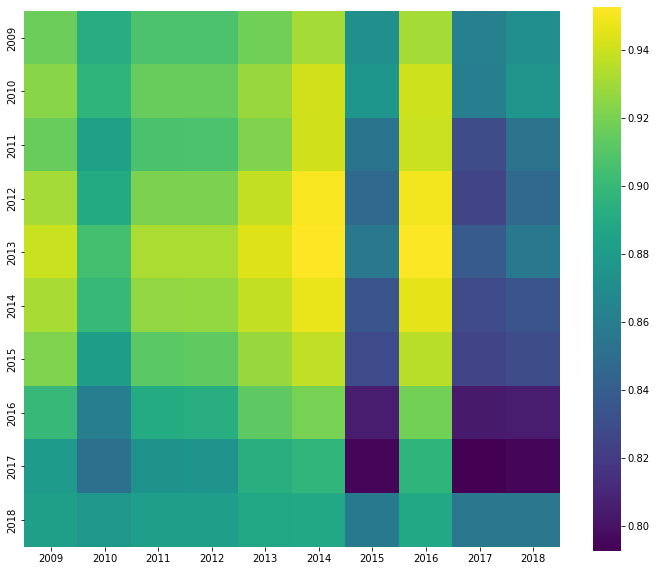

In [86]:
plt.figure(figsize=(12,10))
mask = np.zeros_like(mdf)
mask[np.triu_indices_from(mask)] = False
sns.heatmap(mdf, cmap='viridis', mask=mask, annot=False, square=True)

shap에 의한 feature importance 분석

In [87]:
import shap
import sys
from alibi_detect.cd import ChiSquareDrift, KSDrift

In [88]:
REFERENCE_YEAR = 2013


Generating explanations...


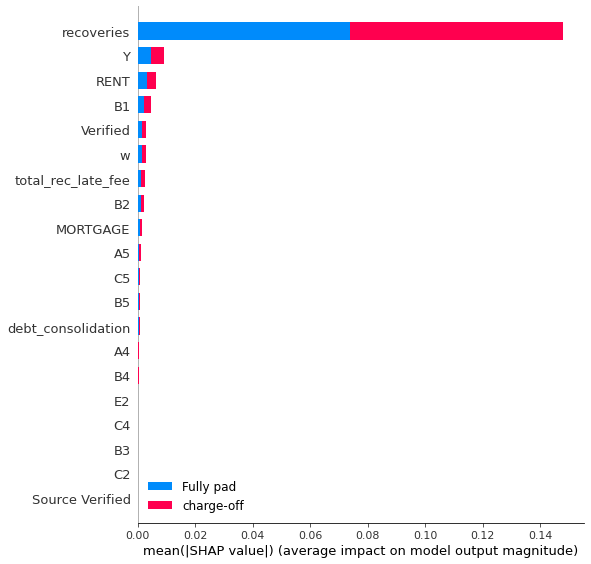

In [92]:

model = ML[REFERENCE_YEAR]
X_test = scaler.fit_transform(X[REFERENCE_YEAR])
y_test = Y[REFERENCE_YEAR]

# ##### EXPLANATIONS #####
print()
print("Generating explanations...")

def predict(data):
    return (model.predict(data) > 0.5).astype("int32")
    
x_columns = df.loc[:, df.columns != 'loan_paid'].columns

X_test_df = pd.DataFrame(X_test,columns=x_columns)

plt.figure(figsize=(30,15))

XAI_Explainer = None
if MODEL_TYPE == 'DL':
    XAI_Explainer = shap.DeepExplainer
else:
    XAI_Explainer = shap.TreeExplainer

explainer = XAI_Explainer(model,X_test)
shap_values = explainer.shap_values(X_test[0:1000])
vals= np.abs(shap_values).mean(0)*2
feature_importance = {}
for (fname,imp_val) in zip(x_columns,np.mean(vals,axis=0)):
    feature_importance[fname] = (imp_val,0,0,0)  # (importance_value, drift, p_val, is_drift)
    
shap.summary_plot(shap_values, X_test_df, show=False, class_names=['Fully pad','charge-off'])
plt.savefig('SHAP_EXPLANATIONS.png', bbox_inches='tight')        


2009년 train data를 기준으로 
bucket size, step size 를 변경하면서 
ks drift를 측정한다!

In [96]:
monitoring_feature = ['recoveries','last_pymnt_amnt','loan_amnt','total_rec_int','int_rate','last_fico_range_high'] if MODEL_TYPE =='DL' else ['recoveries', 'Y', 'RENT', 'B1', 'Verified','w']

In [109]:
import pickle

# 기준 년도의 모델
model = ML[REFERENCE_YEAR]
# 기준 년도의 데이터
df_reference = df_accepted[df_accepted['issue_d'].str.startswith(str(REFERENCE_YEAR))]
start_index = df_reference.index[0]
# reference drift 데이터
drift_ref = df_reference[monitoring_feature].values
# data drift detect...
detect_p_val = 1e-6 if MODEL_TYPE =='DL' else 5e-3
cd = KSDrift(drift_ref, p_val=detect_p_val)

is_do_retrain = True

# 초기 버퍼들 준비
result_data = {}
result_data['model performance'] = []
result_data['model confidence'] = []
for column in monitoring_feature:
    result_data[column + ' KPI'] = []
    result_data[column + ' Drift'] = []
    result_data[column + ' p_val'] = []
drift_point = {} # feature_name:[(x,y),p_val]
drift_status = []
distribution_analysis = []

bucket_size = 10000
step = 1000
retrain_count = 0
now = 0

# 앞으로 비교 진행해야 할 대상 데이터, reference년도의 10월부터의 데이터...
df_for_drift = df_accepted[df_accepted['issue_d']>=str(REFERENCE_YEAR) + '10'][:1100000]
print(len(df_for_drift))
print('='*30 + ' Drift detect from year '+str(REFERENCE_YEAR) + ' '+'='*30)
for i in range(0,df_for_drift.shape[0],step):
    
    now +=1
    cutoff = (i + bucket_size) if (i + bucket_size) < df_for_drift.shape[0] else df_for_drift.shape[0]
    df_x_test = df_for_drift[i:cutoff]

    current_index = df_x_test.index[-1]
    current_day = df_x_test['issue_d'].values[0]

    y_test = df_x_test.loan_paid.values
    df_x_test_without_label = df_x_test.drop(columns=['issue_d','loan_paid'])
    x_test_for_model = df_x_test_without_label.values
    x_test_for_drift = df_x_test_without_label[monitoring_feature].to_numpy()
    
    preds = cd.predict(x_test_for_drift, drift_type='batch', return_p_val=True, return_distance=True)
    fpreds = cd.predict(x_test_for_drift, drift_type='feature')
    is_drift_count = 0
    for f in range(cd.n_features):
        stat = 'K-S'
        fname = monitoring_feature[f]
        is_drift = fpreds['data']['is_drift'][f]
        if is_drift:
            is_drift_count +=1
        stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
        #print(f'{fname}-- Drift? {[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.5f}') 
        result_data[fname + ' KPI'].append(stat_val)
        result_data[fname + ' Drift'].append(is_drift)
        result_data[fname + ' p_val'].append(p_val)

        (f_importance_value, f_drift, f_p_val, f_is_drift) = feature_importance[fname]
        f_drift = stat_val
        f_p_val = p_val
        f_is_drift = is_drift
        feature_importance[fname] = (f_importance_value, f_drift, f_p_val, f_is_drift) 

        if is_drift and fname+str(retrain_count) not in drift_point:
            drift_point[fname+str(retrain_count)] = [(len(result_data[fname + ' KPI'])-1,stat_val),p_val]

    drift_status.append(feature_importance.copy())
    distribution_analysis.append(x_test_for_drift.copy())
    predict_out = model.predict(scaler.fit_transform(x_test_for_model))
    #print(predict_out)
    
    if MODEL_TYPE =='DL':
        confidence = np.mean(np.array(predict_out).max(axis=1))
        y_pred_datadrift = (predict_out[:,1] > 0.5).astype("int32")
    else:
        confidence = np.mean(np.abs(predict_out - 0.5) + 0.5)
        y_pred_datadrift = (predict_out > 0.5).astype("int32")
    
    datadrift_test_acc = accuracy_score(y_test,y_pred_datadrift)
    #print("Datadrift_Test_Accuracy: ",datadrift_test_acc)
    result_data['model performance'].append(datadrift_test_acc)
    result_data['model confidence'].append(confidence)
    print(f'\r {i}/{df_for_drift.shape[0]} step {now} day {current_day} index {current_index} model_ver {retrain_count} drift {is_drift_count} acc {datadrift_test_acc:.4f} cfd {confidence:.4f}', end="", flush=True)

    if is_drift_count == len(monitoring_feature) and is_do_retrain:
        
        print()
        #del model
        del cd
        #print('Delete model...')
        print("="*50 + " Train " + "="*50)
        #new_sample = df_for_drift[df_for_drift.index<=current_index][-len(X_train):]
        mask = (df_accepted.index>=start_index) & (df_accepted.index<=current_index)
        df_reference = df_accepted.loc[mask]
        print(f'new reference data index {start_index}~{current_index}, length {len(df_reference)}')
        # reference drift 데이터
        drift_ref = df_reference[monitoring_feature].values
        cd = KSDrift(drift_ref, p_val=detect_p_val)
        y = df_reference.loan_paid.values
        x = df_reference.drop(columns=['issue_d','loan_paid']).to_numpy()
        if MODEL_TYPE =='DL':
            model = build_model_dl(1000+retrain_count,x,y,epochs=100)
        else:
            model = build_model_rf(1000+retrain_count,x,y,epochs=100)
        retrain_count += 1
        print()


with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "wb") as fp:
    pickle.dump([result_data,drift_point,drift_status,distribution_analysis],fp)

1100000
============================== Drift detect from year 2013 ==============================
 800000/1100000 step 801 day 201606 index 993053 model_ver 0 drift 6 acc 0.9149 cfd 1.0000
================================================== Train ==================================================
new reference data index 92229~993053, length 900825

 1099000/1100000 step 1100 day 201712 index 1283053 model_ver 1 drift 2 acc 0.8960 cfd 1.0000

In [ ]:
import pickle
with open("/content/drive/MyDrive/Drift/drift_result_data.bin", "rb") as fp:
    a = pickle.load(fp)
    result_data = a[0]
    drift_point = a[1]
    drift_status = a[2]
    distribution_analysis = a[3]

In [ ]:

import os
from PIL import Image
from IPython.display import Image as Img
from IPython.display import display
import glob

def generate_gif(path,output_file_name = 'out.gif'):
    img_list = os.listdir(path)
    img_list = [path + '/' + x for x in img_list if x.endswith(".png")]
    images = [Image.open(x) for x in img_list]
    
    im = images[0]
    im.save('out.gif', save_all=True, append_images=images[1:],loop=0xff, duration=200)
    # loop 반복 횟수
    # duration 프레임 전환 속도 (500 = 0.5초)
    return Img(url=output_file_name)

In [ ]:
%rm -f /content/drive/MyDrive/Drift/img/*.png

for cut in range(0,len(drift_status),10):

    status = drift_status[cut]
    drifted_columns = []
    fig, ax = plt.subplots( nrows=1, ncols=1,figsize=(10,10) )  # create figure & 1 axis
    fig.suptitle('Feature importance vs Drift at time '+str(cut))
    plt.xlabel('Feature importance')
    plt.ylabel('Drift KPI')
    for fname in status.keys():
        (importance_value, drift, p_val, is_drift) = status[fname]
        if is_drift:
            drifted_columns.append(fname)
        ax.annotate(fname+':'+str(is_drift), (importance_value,drift),color=('red' if is_drift==1 else 'black'))
        ax.plot([importance_value],[drift],'o')
        ax.grid()
    fig.savefig('/content/drive/MyDrive/Drift/img/IvD_'+str(cut)+'.png')   # save the figure to file
    plt.close(fig)    # close the figure window

In [ ]:
gif = generate_gif('/content/drive/MyDrive/Drift/img')

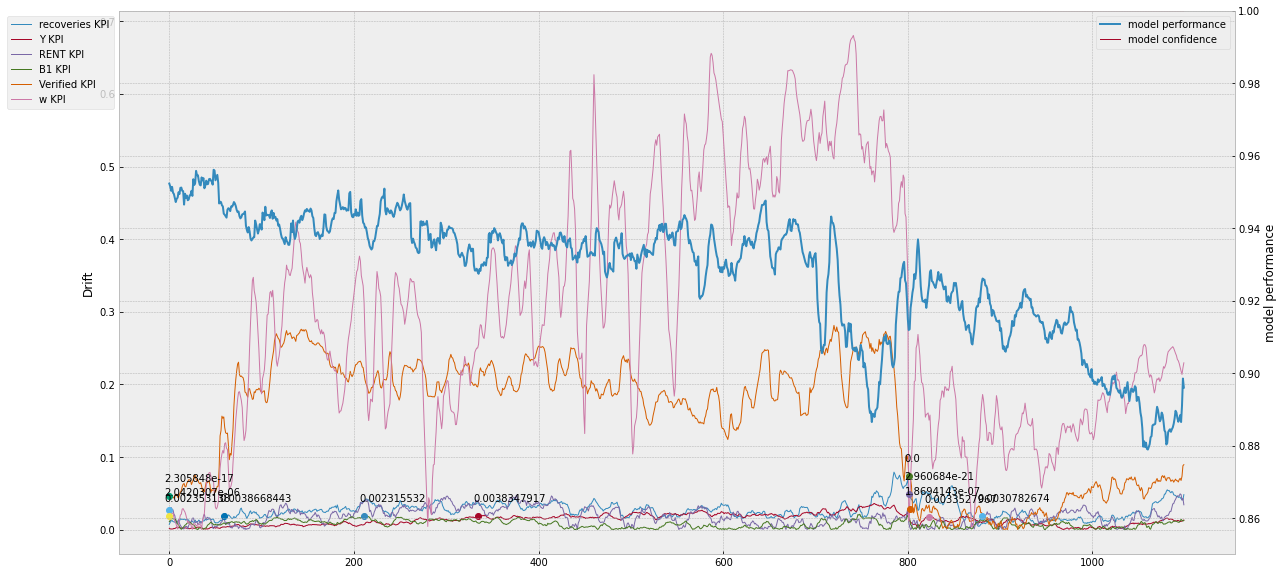

In [111]:
plt.style.use('bmh')
span = 1
result_df = pd.DataFrame(result_data)

ax = result_df[[fname+' KPI' for fname in monitoring_feature]].ewm(span = span).mean().plot(linewidth=1,figsize=(20,10))
ax.set_ylabel("Drift")
for fname in drift_point.keys():
    if fname.startswith(tuple(monitoring_feature)):
        p,p_val = drift_point[fname]
        plt.annotate(str(p_val), (p[0]-5,p[1]+0.02))
        plt.plot([p[0]],[p[1]],'o')
ax_perf = ax.twinx()
ax_perf.set_ylim(0.85, 1.0)
ax_perf.set_ylabel("model performance")
ax_perf.plot(result_df['model performance'].ewm(span = span).mean(),linewidth=2,label='model performance')
ax_perf.plot(result_df['model confidence'].ewm(span = span).mean(),linewidth=1,label='model confidence')
ax_perf.legend()
#ax = result_df['model performance'].ewm(span = 10).mean().plot(linewidth=1,figsize=(20,10))

ax.legend(bbox_to_anchor=(0.0, 1.0))
ax.plot()
plt.show()

In [105]:
result_df.corr()

,model performance,model confidence,recoveries KPI,recoveries Drift,recoveries p_val,Y KPI,Y Drift,Y p_val,RENT KPI,RENT Drift,RENT p_val,B1 KPI,B1 Drift,B1 p_val,Verified KPI,Verified Drift,Verified p_val,w KPI,w Drift,w p_val
model performance,1.000000,NaN,-0.351094,-0.203768,0.255050,-0.277100,-0.367452,0.146050,0.300498,0.254350,-0.236820,0.209912,NaN,-0.265079,-0.313644,NaN,0.060177,-0.577539,-0.242939,0.176678
model confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recoveries KPI,-0.351094,NaN,1.000000,0.654093,-0.301378,0.387884,0.363773,-0.273326,0.215045,0.124923,-0.229419,0.124361,NaN,-0.094345,-0.001945,NaN,-0.067252,0.276256,0.258127,-0.188888
recoveries Drift,-0.203768,NaN,0.654093,1.000000,-0.253629,0.262097,0.202249,-0.263515,0.387625,0.298928,-0.353425,0.101275,NaN,-0.084212,0.070804,NaN,-0.056722,0.142661,0.213957,-0.149402
recoveries p_val,0.255050,NaN,-0.301378,-0.253629,1.000000,-0.306569,-0.076753,0.354653,-0.084362,-0.053081,0.048815,-0.000618,NaN,0.003031,-0.533449,NaN,0.167751,-0.421053,-0.685891,0.582639
Y KPI,-0.277100,NaN,0.387884,0.262097,-0.306569,1.000000,0.614200,-0.854674,-0.081186,-0.092140,0.009245,-0.148721,NaN,0.142104,0.048417,NaN,-0.082006,0.499721,0.302217,-0.206652
Y Drift,-0.367452,NaN,0.363773,0.202249,-0.076753,0.614200,1.000000,-0.260542,-0.119798,-0.148686,0.020772,0.080997,NaN,-0.058720,0.034149,NaN,-0.017983,0.268650,0.074292,-0.052923
Y p_val,0.146050,NaN,-0.273326,-0.263515,0.354653,-0.854674,-0.260542,1.000000,-0.096225,-0.106968,0.078732,0.182888,NaN,-0.158667,-0.096603,NaN,0.087684,-0.428158,-0.338735,0.237733
RENT KPI,0.300498,NaN,0.215045,0.387625,-0.084362,-0.081186,-0.119798,-0.096225,1.000000,0.798164,-0.797385,0.415690,NaN,-0.433032,0.101306,NaN,0.049384,-0.266071,0.050583,-0.056509
RENT Drift,0.254350,NaN,0.124923,0.298928,-0.053081,-0.092140,-0.148686,-0.106968,0.798164,1.000000,-0.421054,0.328205,NaN,-0.338802,0.094638,NaN,0.073591,-0.251707,0.034579,-0.054494


In [89]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [90]:
calculate_pvalues(result_df)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



,model performance,model confidence,recoveries KPI,recoveries Drift,recoveries p_val,last_pymnt_amnt KPI,last_pymnt_amnt Drift,last_pymnt_amnt p_val,loan_amnt KPI,loan_amnt Drift,loan_amnt p_val,total_rec_int KPI,total_rec_int Drift,total_rec_int p_val,int_rate KPI,int_rate Drift,int_rate p_val,last_fico_range_high KPI,last_fico_range_high Drift,last_fico_range_high p_val
model performance,0,0,0,0,0,0,0,0,0,0,0.0001,0,0,0.0041,0.1208,NaN,0.1273,0,0,0
model confidence,0,0,0,0.0028,0.0532,0,0.002,0.643,0,0,0.1822,0,0.266,0.1725,0.0493,NaN,0.4321,0,0.0007,0.3676
recoveries KPI,0,0,0,0,0,0,0,0,0,0,0.0053,0,0,0.0232,0.9072,NaN,0.2226,0,0,0
recoveries Drift,0,0.0028,0,0,0,0,0,0,0,0.183,0.0169,0,0,0.0205,0.0765,NaN,0.2243,0,0,0
recoveries p_val,0,0.0532,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0
last_pymnt_amnt KPI,0,0,0,0,0,0,0,0,0,0,0.0024,0,0,0.0411,0.0001,NaN,0.2818,0,0,0
last_pymnt_amnt Drift,0,0.002,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.002,0,0,0
last_pymnt_amnt p_val,0,0.643,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0545,0,0,0
loan_amnt KPI,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0051,0.1083,NaN,0.1295,0,0,0
loan_amnt Drift,0,0,0,0.183,0,0,0,0,0,0,0,0,0,0.0001,0,NaN,0.0318,0,0,0
